## Indexing

-- Multi Representation indexing:
First we generate a summary for a document using an LLM, and we store the document in a particular document DB. Then during retrieval we use the summary to retrieve the full document.


In [ ]:
! pip -q install langchain_community tiktoken langchain-deepseek langchainhub chromadb langchain_chroma langchain dotenv bs4 langchain-text-splitters langchain-ollama

In [ ]:
# Setup

import os
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
from langchain_deepseek import ChatDeepSeek

load_dotenv()

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

# Loading my LLM API Key

EMBEDDING_MODEL_NAME = "qwen3-embedding:0.6b"
DEEPSEEK_MODEL_NAME='deepseek-chat'

OLLAMA_EMBEDDING = OllamaEmbeddings(model=EMBEDDING_MODEL_NAME)
DEEPSEEK_LLM = ChatDeepSeek(model=DEEPSEEK_MODEL_NAME, temperature=0, api_key=os.getenv('DEEPSEEK_API_KEY'))


In [ ]:
## Loading

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader('https://lilianweng.github.io/posts/2023-06-23-agent/')
docs = loader.load()

loader = WebBaseLoader('https://lilianweng.github.io/posts/2024-02-05-human-data-quality/')
docs.extend(loader.load())


In [ ]:
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {'doc': lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | DEEPSEEK_LLM
    |StrOutputParser()
)

summaries = chain.batch(docs, {'max_concurrency': 5})

In [ ]:
summaries

In [ ]:
import uuid

from langchain_classic.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain_classic.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(collection_name="summaries", embedding_function= OLLAMA_EMBEDDING)

store = InMemoryByteStore()
id_key = 'doc_id'

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(summaries)
]

# Add 
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
query = "High quality annotated data"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

In [ ]:
retrieved_docs = retriever.invoke(query) # In the new version we no longer use get_relevant_document, rather we use invoke.
retrieved_docs[0].page_content

## Raptor

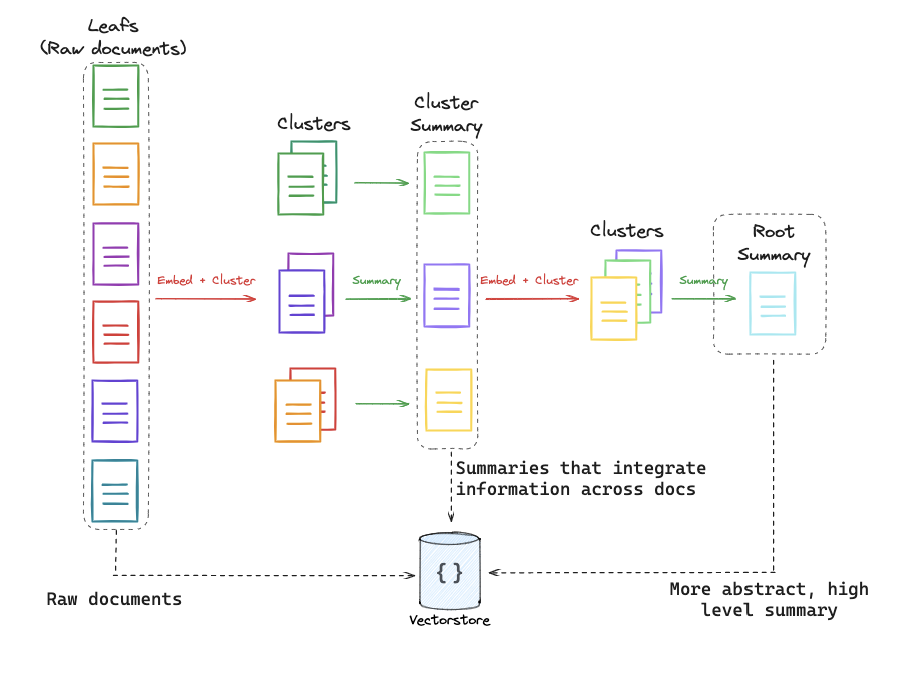

When do we use it:
- When we have a question that requires information that is collected from multiple documents in the corpus. (Often highlevel questions only)
> For Inv this seems to be a good thing for it.


In [ ]:
! pip -q install -U umap-learn scikit-learn langchainhub matplotlib pandas

In [ ]:
# Loading documents

import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

def num_tokens_from_string(text: str, encoding_name: str) -> int:
    """
    Returns the number of tokens in a text string.
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_token = len(encoding.encode(text))
    return num_token

url = "https://react.dev/learn"

loader = RecursiveUrlLoader(
    url=url,
    max_depth=5,
    extractor=lambda x: Soup(x, "html.parser").text
)

react_docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://www.untitledui.com/react/components"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=2,
    extractor= lambda x: Soup(x, 'html.parser').text
)
react_components_docs = loader.load()

# LCEL w/ Install docs
url = "https://react.dev/reference/react/hooks"
loader = RecursiveUrlLoader(
    url=url,
    max_depth=1,
    extractor= lambda x: Soup(x, 'html.parser').text
)

react_hooks = loader.load()

react_docs.extend([*react_components_docs, *react_hooks])
react_docs_text = [d.page_content for d in react_docs]

counts = [num_tokens_from_string(d, 'cl100k_base') for d  in react_docs_text]

# Plotting on histogram:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="green", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show

In [ ]:
# Clustering

from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd 
import umap

from langchain_classic.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

def global_cluster_embeddings(
        embeddings: np.ndarray,
        dim: int,
        n_neighbors: Optional[int] = None,
        metric: str = 'cosine'
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
        - embeddings: The input embeddings as a numpy array.
        - dim: The target dimensionality for the reduced space.
        - n_neighbors: Optional; the number of neighbors to consider for each point.
            If not provided, it defaults to the square root of the number of embeddings.
        - metric: The distance metric to use for UMAP.

    Returns:
        - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if not n_neighbors:
        n_neighbors = int((len(embeddings) -1) ** 0.5)
    
    return umap.UMAP(
        n_neighbors=n_neighbors, 
        n_components=dim,
        metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
        embeddings: np.ndarray,
        dim: int,
        n_neighbors: Optional[int] = 10,
        metric: str = 'cosine'
) -> np.ndarray:
    """
    Performs a local dimesionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
        - embeddings: The input embeddings as a numpy array.
        - dim: The target dimensionality for the reduced space.
        - n_neighbors: Optional; the number of neighbors to consider for each point (default: 10).
        - metric: The distance metric to use for UMAP.

    Returns:
        - A numpy array of the embeddings reduced to the specified dimensionality.    
    """
    return umap.UMAP(
        n_neighbors=n_neighbors, 
        n_components=dim,
        metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
        embeddings: np.ndarray,
        max_clusters: int = 50,
        random_state: int = RANDOM_SEED,
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Models.

    Parameters:
    - embeddings: The input embeddings as a numpy array
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []

    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))

    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number og clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(probs > threshold)[0] for prob in probs]
    return labels, n_clusters

def perform_clustering(
        embeddings:np.ndarray,
        dim: int,
        threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the emberddings by first reducing their dimensionality globally, then clustering using a Gaussian Mixture Model,
    and finally performing local clustering within each global cluster.

    Parameters:
        - embeddings: The input embeddings as a numpy array.
        - dim: The target dimensionality for UMAP reduction.
        - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
        - A list of numpy arrays, where each array contains the cluster IDs for each embedding. 
    """
    if len(embeddings) <= dim +1:
        # Avoid clustering when there is insufficient data.
        return [ np.array([0]) for _ in range(len(embeddings)) ]

    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    global_clusters, n_global_clusters = GMM_cluster(reduced_embeddings_global, threshold)

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0
    
    # Iterate through each gloabal cluster to perform local clustering.
    for i in range(n_global_clusters):
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]
        if len(global_cluster_embeddings_) == 0:
            continue
        
        if len(global_cluster_embeddings_)<= dim+1:
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            reduced_embeddings_local = local_cluster_embeddings(global_cluster_embeddings_, dim)
            local_clusters, n_local_clusters = GMM_cluster(reduced_embeddings_local, threshold)

        # Assing local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(all_local_clusters[idx], j + total_clusters)
        
        total_clusters += n_local_clusters

    return all_local_clusters


In [ ]:
embd = OLLAMA_EMBEDDING

In [ ]:
# Process orchestration

def embed(text) -> np.ndarray:
    """
    Generates embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents` that takes a list of texts and returns their embeddings.

    Parameter:
        - texts: List[str], a list of text documents to be embedded.

    Returns:
        - numpy.ndarray: An array of embeddings for the given text documents
    """
    text_embeddings = embd.embed_documents(text)
    text_embeddings_np = np.array(text_embeddings)

    return text_embeddings_np

def embed_cluster_texts(texts):
    """
    Embeds a list of textr and clustees them, returning a dataframe with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering inro a single step. It assumes the existence of a previouslt defined
    `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
        - texts: List[str], a list of text docmuments to be processed.
    
    Returns:
        - pandas.Dataframe: a Dataframe containing the original texts, their embeddings, and tne assigned cluster labels.
    """
    text_embeddings_np = embed(texts)
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)
    df =pd.DataFrame()
    df['text'] = texts
    df['embd'] = list(text_embeddings_np)
    df['cluster'] = cluster_labels

    return df

def fmt_text(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a Dataframe into a single string.

    Parameters:
    - df: Dataframe containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df['text'].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

def embed_cluster_summarize_texts(texts: List[str], level: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts, clusters them based on similarity,
    expands the cluster assignments for easier processing, and then summarizes the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    -  Tuple containing 2 DataFrames:
    1. df_clusters, includes the original text, their embeddings, and cluster assignments.
    2. df_summary, contains summaries for each cluster, the specified level of detail, and the cluster identifiers.
    """
    df_clusters = embed_cluster_texts(texts)
    expanded_list = []

    for idx, row in df_clusters.iterrows():
        for cluster in row['cluster']:
            expanded_list.append({
                'text': row['text'], 'embd': row['embd'], 'cluster': cluster
            })
    
    expanded_df = pd.DataFrame(expanded_list)

    all_clusters = expanded_df['cluster'].unique()

    print(f'--- Generated {len(all_clusters)} clusters ---')

    template = """
    Here is a sub-set of Langchain expression language doc.

    Langchain Expression language provides a way to compose chain in Langchain.
    Give a detailed summary of the docummentation provided.

    Documentation:
    {context}
    """
    prompt =  ChatPromptTemplate.from_template(template)
    chain = prompt | DEEPSEEK_LLM | StrOutputParser()
    summaries = []

    for i in all_clusters:
        df_cluster  = expanded_df[expanded_df['cluster'] == i]
        formatted_txt = fmt_text(df_cluster)
        summaries.append(chain.invoke({'context': formatted_txt}))
    
    df_summary = pd.DataFrame(
        {
            'summaries': summaries,
            'level': [level] * len(summaries),
            'cluster': list(all_clusters)
        }
    )

    return df_cluster, df_summary

def recursive_embed_cluster_summarize(texts: List[str], level: int = 1, n_levels: int = 3):

    results ={}
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)
    results[level] = (df_clusters, df_summary)
    unique_clusters = df_summary['cluster'].nunique()
    if level < n_levels and unique_clusters > 1:
        new_texts = df_summary['summaries'].tolist()
        next_level_results = recursive_embed_cluster_summarize(new_texts, level+1, n_levels)
        results.update(next_level_results)
    
    return results

leaf_texts = docs_text
results = recursive_embed_cluster_summarize(texts=leaf_texts, level=1, n_levels=3)



In [ ]:
from langchain_chroma import Chroma

all_texts = leaf_texts.copy()

for level in sorted(results.keys()):
    summaries = results[level][1]['summaries'].tolist()
    all_texts.extend(summaries)

vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()


In [ ]:
from langchain_classic import hub
from langchain_core.runnables import RunnablePassthrough

prompt = hub.pull('rlm/rag-prompt')

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

rag_chain =(
    {'context': retriever | format_docs, 'question': RunnablePassthrough()}
    | prompt
    | DEEPSEEK_LLM
    | StrOutputParser()
)

rag_chain.invoke("How to install langchain? Give a specific code example.")

## ColBERT

This is an approach where you first take a document and split it into multiple tokens, then embedd the tokens. While on the other side, you split the question into multiple tokens then embedd them too (tokenwise embedding). And for each embedding of the question you calculate the maximum similarity accross all the embeddings of the document. Finally you make the sum for each maximum similarity.

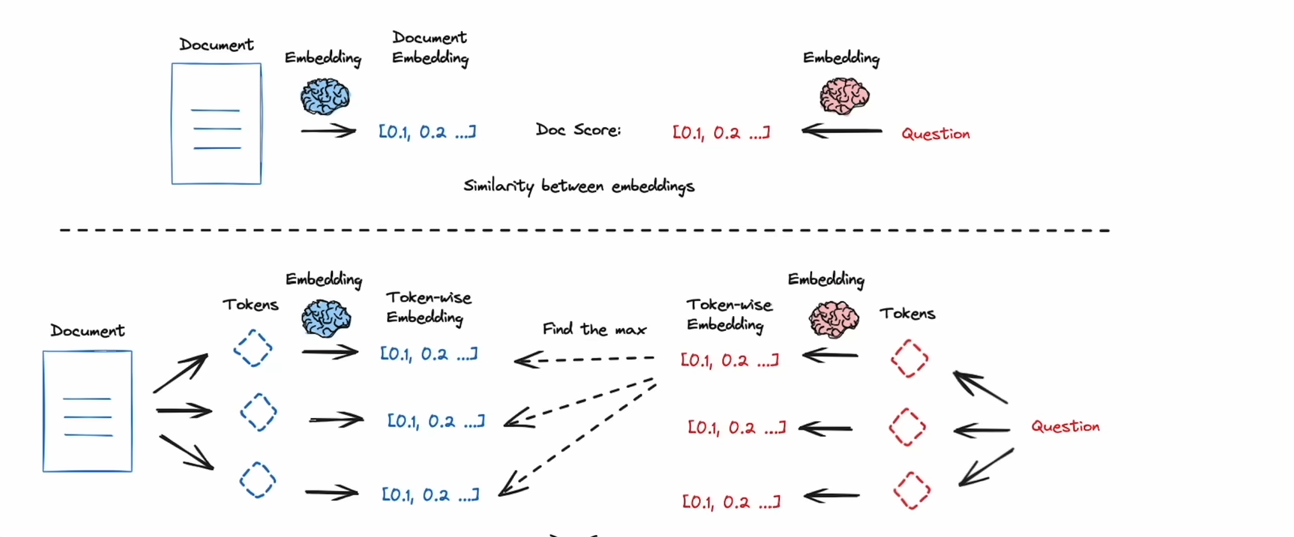


In [ ]:
%pip install -q pylate

# So it seems that the latest version of ragatouille moved to pylate, so in case you want to use the ColBERT approach look at this docs - https://lightonai.github.io/pylate/#retrieval

In [ ]:
from pylate import indexes, models, retrieve


model = models.ColBERT(
    # model_name_or_path="lightonai/GTE-ModernColBERT-v1",
    model_name_or_path="colbert-ir/colbertv2.0"
)

index = indexes.PLAID(
    index_folder="pylate-index",
    index_name="index",
    override=True,
)

retriever = retrieve.ColBERT(index=index)

In [ ]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    Args:
        - title: Title of the Wikipedia page
    
    Returns:
        - Full text content of the page as a raw string.
    """
    URL = 'https://en.wikipedia.org/w/api.php'

    params = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'extracts',
        'explaintext': True
    }

    header = {'User-Agent': "RAGatouille_tutorial/0.0.10(ben@clavie.eu)"}
    response = requests.get(URL, params=params, headers=header)
    data = response.json()

    page = next(iter(data['query']['pages'].values()))

    return page['extract'] if 'extract' in page else None

full_document = get_wikipedia_page('Hayao_Miyazaki')

In [ ]:
document_ids = ['1']
document_embeddings = model.encode(
    [full_document],
    batch_size=32,
    is_query=False,
    show_progress_bar=True
)

index.add_documents(
    documents_ids=document_ids,
    documents_embeddings=document_embeddings
)

queries_embeddings = model.encode(
    ["Who is Hayako?"],
    batch_size=32,
    is_query=True, # Encoding queries
    show_progress_bar=True,
)


scores = retriever.retrieve(
    queries_embeddings=queries_embeddings,
    k=10,
)

print(scores)
